# Machine Learning Homework 7 - Dimension Reductions
##### 0756021 張逸群

This homework aims to implement several dimension reduction methods and apply one of them to the face dataset.

In [1]:
import numba
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

%matplotlib inline

## I. Different ways to do dimension reductions

For the first part, there four methods are implemented:
* PCA
* LDA
* SSNE
* T-SNE  

The dataset used here is a subset of MNIST dataset, which contains handwritings of 0 to 4.  
I choose the `pandas` package to read CSV files and save both X (handwriting image) and y (label) as `np.arrays`.

## Load data

In [2]:
X = pd.read_csv('./mnist_X.csv', header=None).values
y = pd.read_csv('./mnist_label.csv', header=None).values
y = y.reshape(y.shape[0])

#### Plot the first image in each group

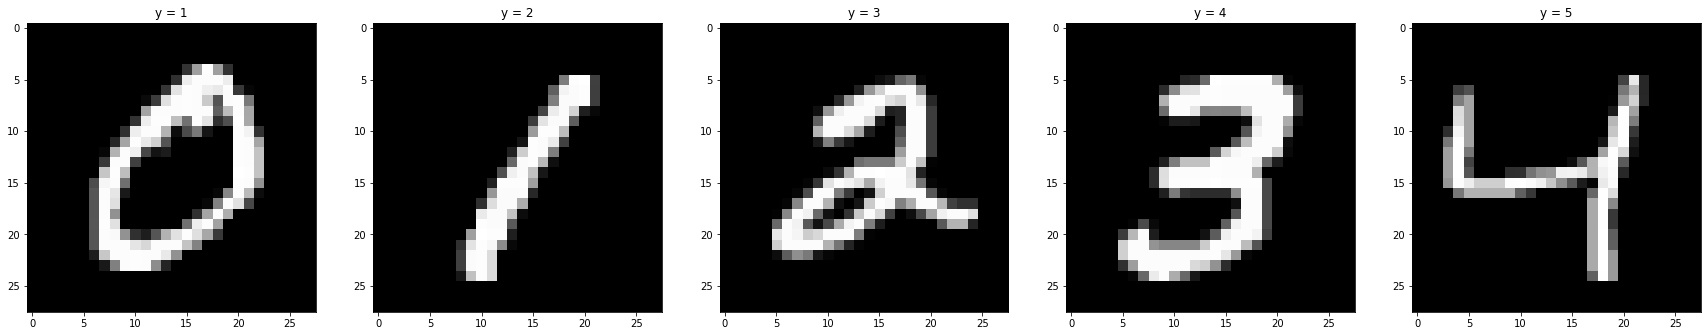

In [3]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(30, 6))
for i, ax, in enumerate(axes):
    xi = X[np.where(y == i+1)[0][0]]
    ax.imshow(xi.reshape(28, 28).T, cmap='gray')
    ax.set_title('y = {:d}'.format(i+1))
plt.show()

### A. PCA

PCA guarantees the minimum distances between the transferred data and the new axes, and output the new axes sorted base on importance, which is essential in some applications.  
It follows these steps:
1. Standardization - subtract the data by each axis' mean
	* This is quite significant since PCA demands the data be zero centered.
0. Calculate the covariance matrix.
0. Calculate the eigenvalues and eigenvectors and sort them by eigenvalues in decreasing order.
	* The eigenvalues stand for the importance of each new axis.
0. Project the data to the new space obtained by the first `rank` eigenvectors as new axes. 

In [4]:
def pca(X, rank=2, return_vectors=False):
    def standardized(X):
        return X - X.mean(axis=0) #  / X.std(axis=0)
    
    original_shape = list(X.shape[1:])
    X = X.reshape((X.shape[0], -1)) # flatten
    X = standardized(X)
    cov = np.cov(X.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    
    # get first `rank` eigenvectors
    eigenvectors = (eigenvectors[:, np.argsort(eigenvalues)[::-1]])[:, :rank]
    if return_vectors:
        return (eigenvectors.T @ X.T).T, eigenvectors.T.reshape([eigenvectors.shape[1]] + original_shape)

    return (eigenvectors.T @ X.T).T

X_pcaed = pca(X)

#### Result

The result can be found below.  
While clusters are basically separated, the dark green group is still "buried" inside other groups. 

/home/toosyou/.local/lib/python3.6/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


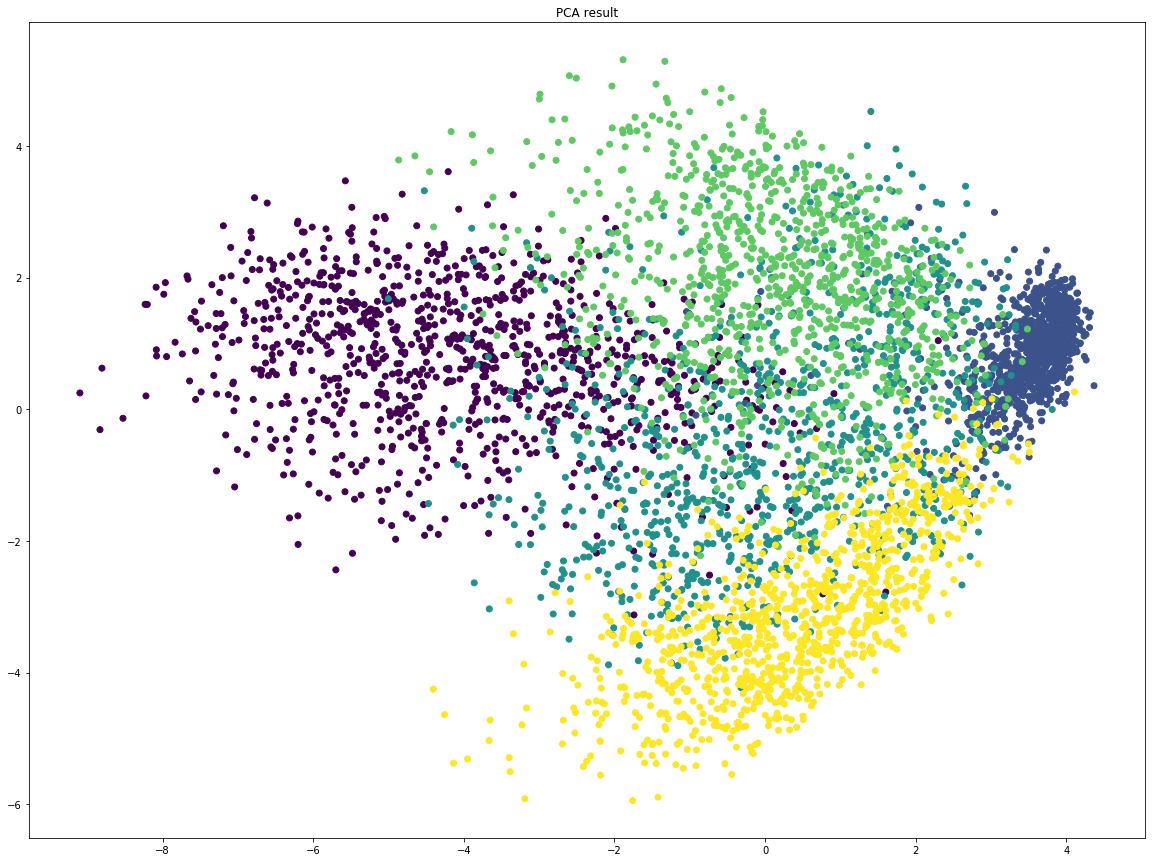

In [5]:
plt.figure(figsize=(20, 15))
plt.scatter(X_pcaed[:, 0], X_pcaed[:, 1], c=y)
plt.title('PCA result')
plt.show()

### B. LDA

LDA utilizes the information of labels as it's a supervised dimension reduction method. It tries to minimize the within-class scatter while maximizing the between-class scatter.
LDA has the following steps:
1. Calculate within-class scatter, $S_w$
2. Calculate between-class scatter, $S_b$
3. Calculate eigenvalues and eigenvectors of $S_w^{-1}S_b$
4. Project data to the new space obtained by the first `rank` eigenvectors.

$$S_w = \sum_{j=1}^{L} S_j$$, and
$$S_j = \sum_{i \notin C_j}{(x_i - m_j)(x_i - m_j)^T}$$,
where $m_j$ is the mean of the j-th group 

$$S_b = \sum_{j=1}^{L} S_i^{between}$$, and
$$S_i^{between} = \sum_{j=1, i \neq j}^L{(m_i - m_j)(m_i - m_j)^T}$$

In [6]:
def lda(X, y, rank=2):
    def calculate_sw(X, y, unique_y):
        def sj(X):
            mean = X.mean(axis=1)[..., np.newaxis] # (n_dim, 1)
            return (X - mean) @ (X - mean).T
        
        return np.array([sj(X[:, y == uy]) for uy in unique_y]).sum(axis=0)
    
    def calculate_sb(X, y, unique_y):
        means = np.array([X[:, y==uy].mean(axis=1) for uy in unique_y]) # (n_group, n_dim)
        return np.array([(-(means - means[i])).T @ (-(means - means[i])) for i in range(means.shape[0])]).sum(axis=0)
    
    X = X.reshape((X.shape[0], -1)).T # flatten and transpose # (n_dim, n_sample)
    unique_y = np.unique(y)
    sw = calculate_sw(X, y, unique_y) + np.identity(X.shape[0]) # deal with singular matrix issue
    sb = calculate_sb(X, y, unique_y)
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(sw) @ sb)
    
    # get first `rank` eigenvectors
    eigenvectors = (eigenvectors[:, np.argsort(eigenvalues)[::-1]])[:, :rank]
    return (eigenvectors.T @ X).T

X_ldaed = lda(X, y)

#### Result

Due to the power of supervised learning, the result of dimension reduction is pretty promising.  
The groups are even more separated than the ones produced by PCA.  
The dark green group, however, is still buried under the light green group. These two groups might be somehow similar.

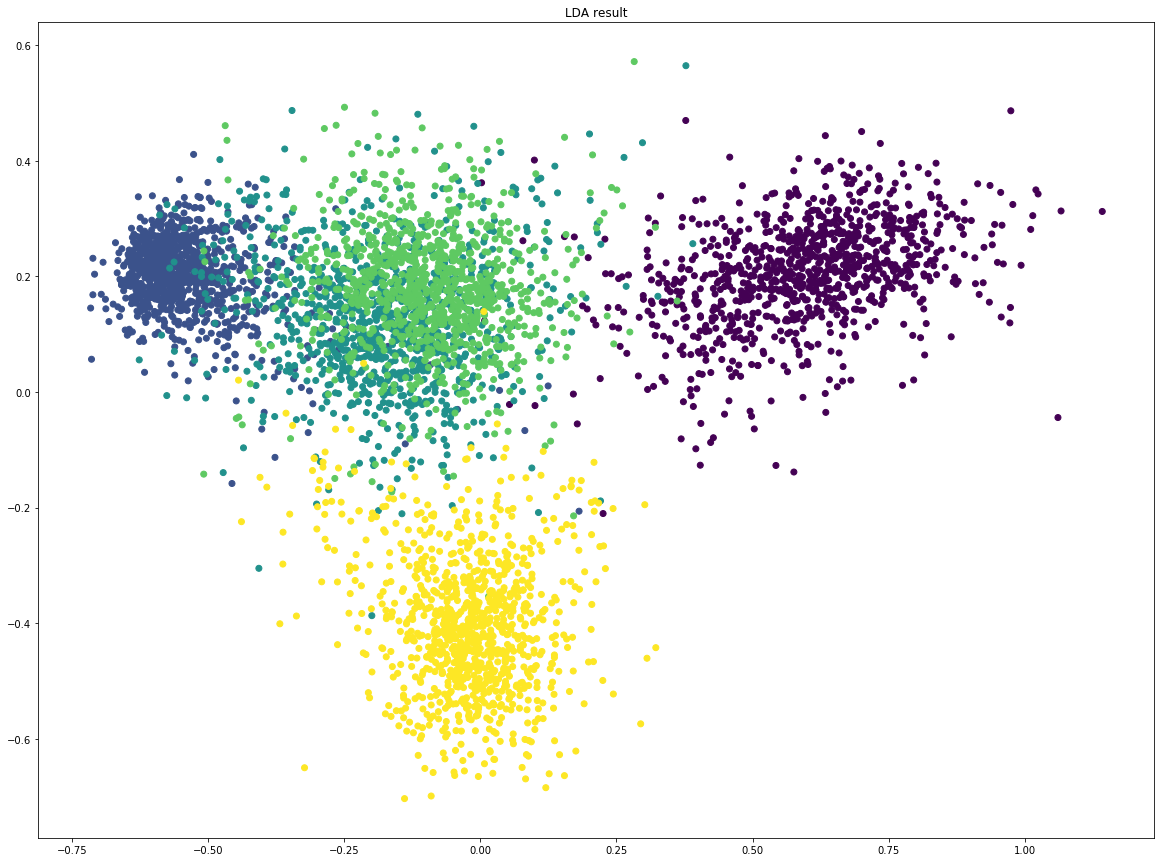

In [7]:
plt.figure(figsize=(20, 15))
plt.scatter(X_ldaed[:, 0], X_ldaed[:, 1], c=y)
plt.title('LDA result')
plt.show()

### C. Symmetric SNE & T-SNE

SSNE and T-SNE are both based on the same SNE algorithm but different ways of measuring distances (similarity).  
The following block of codes is provided by TA, and modified for performance.  
It follows there steps:  
0. Perform PCA to reduce the input dimension and speed up the following process.
1. Perform a binary search to get P-values with the exact perplexity given.
	* P-values are distances between data points in the original (high) dimension. 
2. Compute the Q-values base on the function given. 
	* Q-values are distances between data points in the lower dimension.
3. Use KL divergence to measure the distance between P and Q distributions, and use the gradient descent algorithm to compute the gradient and update the parameters accordingly.
4. Repeat step 2 and 3 for some number of iterations.

#### SNE Base Function

In [8]:
# Provided by TA
@numba.njit()
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

@numba.jit()
def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    # print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        # if i % 500 == 0:
        #     print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    # print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

def sne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, q_distance_function=None, gradient_function=None):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims) # .real
    (n, d) = X.shape
    max_iter = 200
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    # np.random.seed(42) # for debug
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    print('iteration start!')
    for iter in range(max_iter):

        # Compute pairwise affinities
        num, Q = q_distance_function(Y, n)

        # Compute gradient
        dY = gradient_function(P, Q, n, num, no_dims, Y)
        
        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
            
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))
        
        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 50:
            P = P / 4.

    # Return solution
    return Y, P, Q

#### Symmetric SNE

Due to the difficulty of optimizing SNE, Symmetric SNE is introduced.
It focuses on making the $p_{i|j} = p_{j|i}$, so that it'll be easier to be optimized.  
As a result, Symmetric SNE makes $p_{i,j} = \frac{p_{i|j} + p_{j|i}}{2}$ and replace the original $p_{i|j}$ by it.

It also changes $q_{i|j}$ to $q_{i,j}$ by:
$$q_{i,j} = \frac{\exp(- \mid  \mid y_i - y_j \mid  \mid ^2)}{\sum_{k \neq l} \exp(- \mid  \mid y_k-y_l \mid  \mid ^2)}$$

So the final gradient would be:
$$\frac{\delta C}{\delta y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i - y_j)$$

In [9]:
@numba.njit(parallel=True)
def calculate_gradient(P, Q, n, num, no_dims, Y):
    PQ = P - Q
    dY = np.zeros((n, no_dims))
    for i in numba.prange(n):
        pqnum = PQ[:, i] # * num[:, i]
        for j in numba.prange(no_dims):
            ydiff = (Y[i, j] - Y[:, j])
            dY[i, j] = (ydiff * pqnum).sum()
    return dY

@numba.njit(parallel=True)
def calculate_pairwise_affinities(Y, n):
    sum_Y = np.sum(np.square(Y), 1)
    num = -2. * np.dot(Y, Y.T)
    num = np.exp( -np.add(np.add(num, sum_Y).T, sum_Y) )
    for i in numba.prange(n): num[i, i] = 0
    Q = num / np.sum(num)
    Q = np.maximum(Q, 1e-12)
    return num, Q

X_ssned, P_ssne, Q_ssne = sne(X, 2, 50, 20.0, calculate_pairwise_affinities, calculate_gradient)

/home/toosyou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: ComplexWarning: Casting complex values to real discards the imaginary part


iteration start!
Iteration 10: error is 26.714402
Iteration 20: error is 23.870878
Iteration 30: error is 19.017245
Iteration 40: error is 18.789576
Iteration 50: error is 19.054635
Iteration 60: error is 3.007415
Iteration 70: error is 2.689541
Iteration 80: error is 2.608454
Iteration 90: error is 2.590439
Iteration 100: error is 2.578364
Iteration 110: error is 2.549676
Iteration 120: error is 2.504907
Iteration 130: error is 2.480713
Iteration 140: error is 2.476907
Iteration 150: error is 2.474930
Iteration 160: error is 2.473084
Iteration 170: error is 2.470499
Iteration 180: error is 2.466656
Iteration 190: error is 2.455457
Iteration 200: error is 2.441706


#### Result


The result of dimension reduction by Symmetric SNE is shown below.  
Although SSNE method is unsupervised, one can clearly tell the result of it is far better than the one of LDA, which is supervised.  
On the other hand, the gaps between groups are, however, not that huge to be told apart.

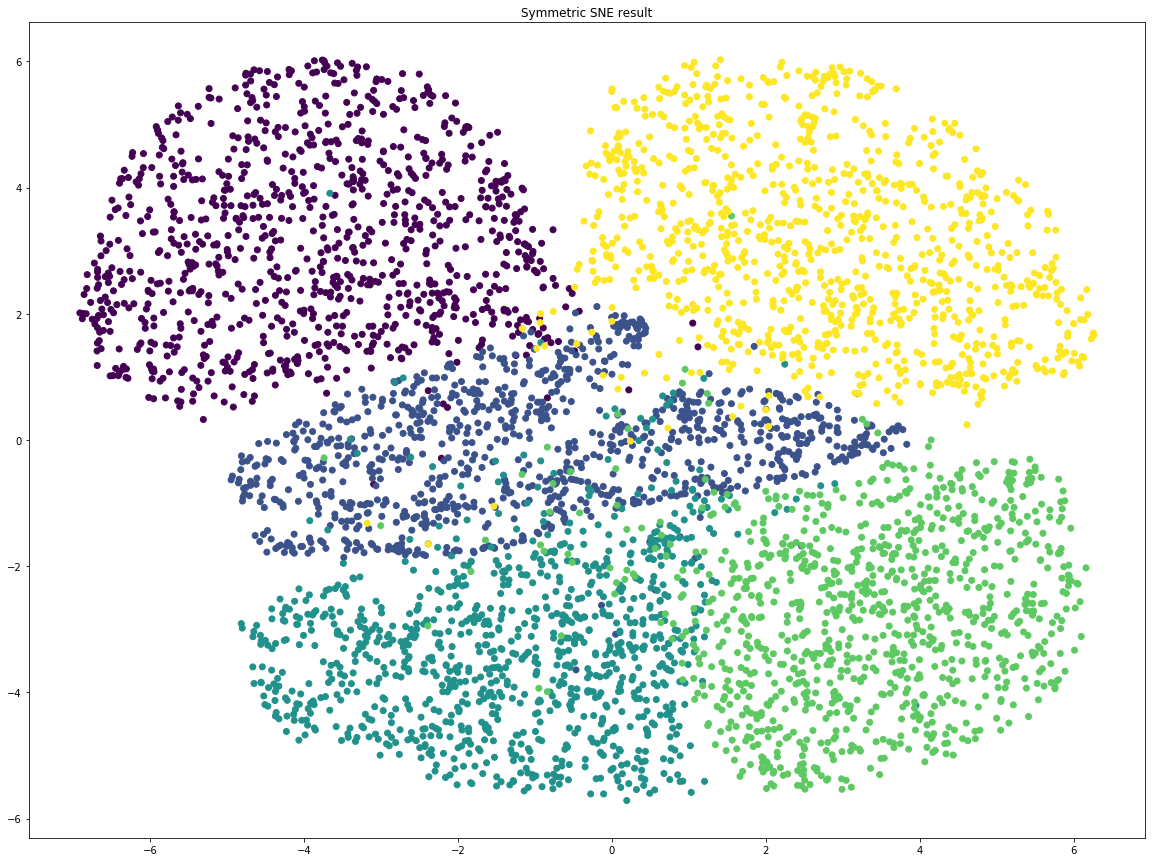

In [10]:
plt.figure(figsize=(20, 15))
plt.scatter(X_ssned[:, 0], X_ssned[:, 1], c=y)
plt.title('Symmetric SNE result')
plt.show()

#### P & Q distribution comparison

The following chart shows the comparison of distributions of P and Q.  
However, due to the inconsistency of the scales, it's hard to tell any story.

Text(0, 0.5, 'counts')

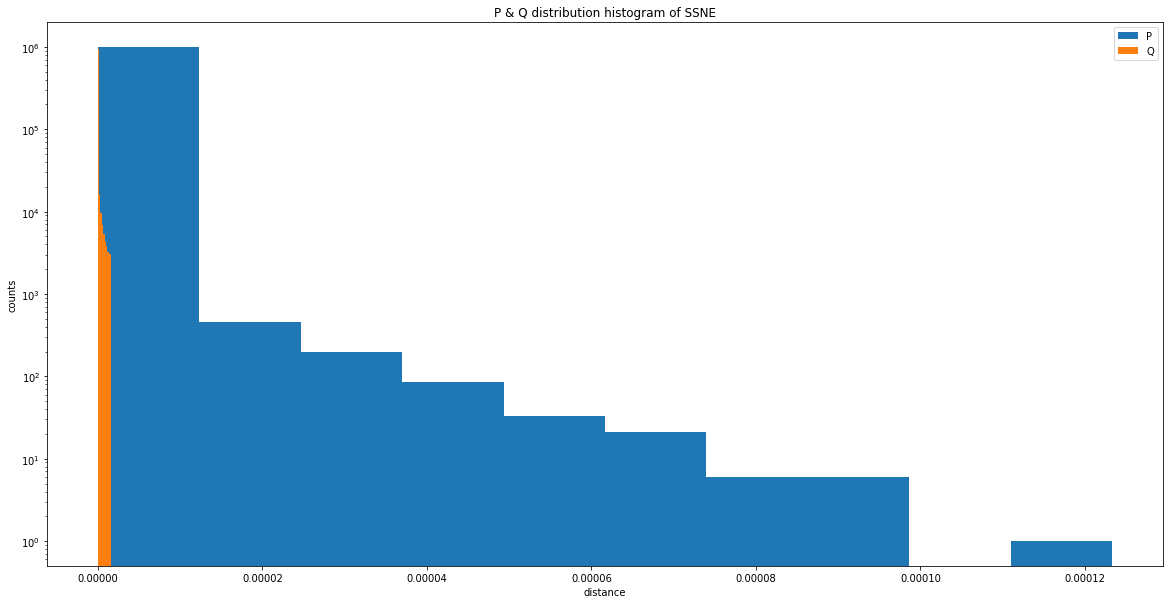

In [11]:
plt.figure(figsize=(20, 10))
plt.hist(np.random.choice(P_ssne.flatten(), size=1000000), log=True, label='P')
plt.hist(np.random.choice(Q_ssne.flatten(), size=1000000), log=True, label='Q')
plt.legend()
plt.title('P & Q distribution histogram of SSNE')
plt.xlabel('distance')
plt.ylabel('counts')

#### T-SNE

After the improvement of Symmetric SNE, T-SNE takes a step further to change $q_{i,j}$  to a Student's t-distribution  $$ q_{i,j} = \frac{(1 +  \mid  \mid y_i -y_j \mid  \mid ^2)^{-1}}{\sum_{k \neq l} (1 +  \mid  \mid y_i -y_j \mid  \mid ^2)^{-1}}$$
which is believed to be able to ease the "Crowding Problem".  
As a consequence, two not-so-similar points in high dimension would be separated in the lower dimension by a larger margin but not infinite.

Accordingly, the gradient of T-SNE is $$\frac{\delta C}{\delta y_i} = 4 \sum_j(p_{ij}-q_{ij})(y_i-y_j)(1+ \mid  \mid y_i-y_j \mid  \mid ^2)^{-1}$$

In [12]:
@numba.njit(parallel=True)
def calculate_gradient(P, Q, n, num, no_dims, Y):
    PQ = P - Q
    dY = np.zeros((n, no_dims))
    for i in numba.prange(n):
        pqnum = PQ[:, i] * num[:, i]
        for j in numba.prange(no_dims):
            ydiff = (Y[i, j] - Y[:, j])
            dY[i, j] = (ydiff * pqnum).sum()
    return dY

@numba.njit(parallel=True)
def calculate_pairwise_affinities(Y, n):
    sum_Y = np.sum(np.square(Y), 1)
    num = -2. * np.dot(Y, Y.T)
    num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
    for i in numba.prange(n): num[i, i] = 0
    Q = num / np.sum(num)
    Q = np.maximum(Q, 1e-12)
    return num, Q

X_tsned, P_tsne, Q_tsne = sne(X, 2, 50, 20.0, calculate_pairwise_affinities, calculate_gradient)

/home/toosyou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: ComplexWarning: Casting complex values to real discards the imaginary part


iteration start!
Iteration 10: error is 26.584735
Iteration 20: error is 25.440758
Iteration 30: error is 21.576034
Iteration 40: error is 19.676243
Iteration 50: error is 18.923726
Iteration 60: error is 3.032029
Iteration 70: error is 2.789984
Iteration 80: error is 2.611998
Iteration 90: error is 2.468588
Iteration 100: error is 2.351147
Iteration 110: error is 2.254230
Iteration 120: error is 2.172597
Iteration 130: error is 2.102710
Iteration 140: error is 2.042184
Iteration 150: error is 1.989201
Iteration 160: error is 1.942386
Iteration 170: error is 1.900700
Iteration 180: error is 1.863378
Iteration 190: error is 1.829754
Iteration 200: error is 1.799245


#### Result

The result of T-SNE dimension reduction is shown below.   
It's obvious that the gaps between groups are larger than ones in SSNE, that is, T-SNE outperforms SSNE in this case.  

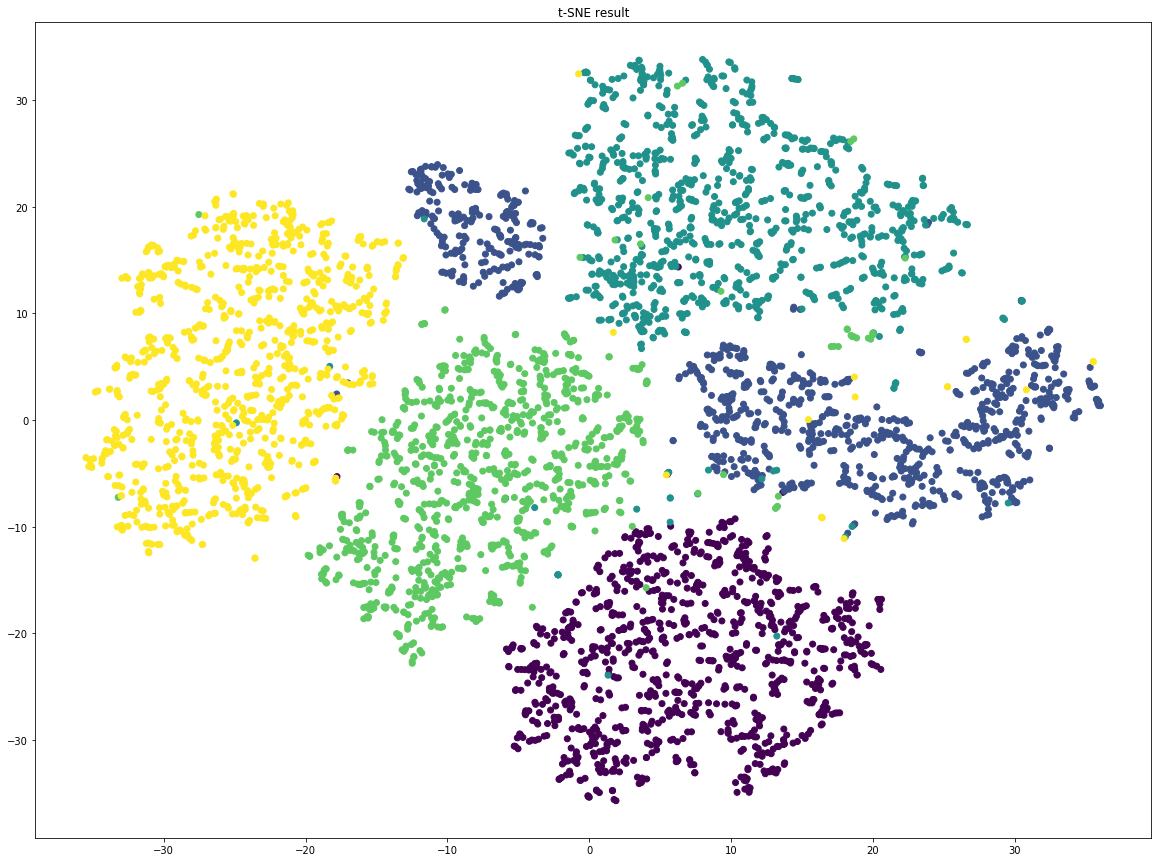

In [13]:
plt.figure(figsize=(20, 15))
plt.scatter(X_tsned[:, 0], X_tsned[:, 1], c=y)
plt.title('t-SNE result')
plt.show()

#### P & Q distribution comparison

The following chart shows the comparison of distributions of P and Q.  
However, due to the inconsistency of the scales, it's hard to tell any story.

Text(0, 0.5, 'counts')

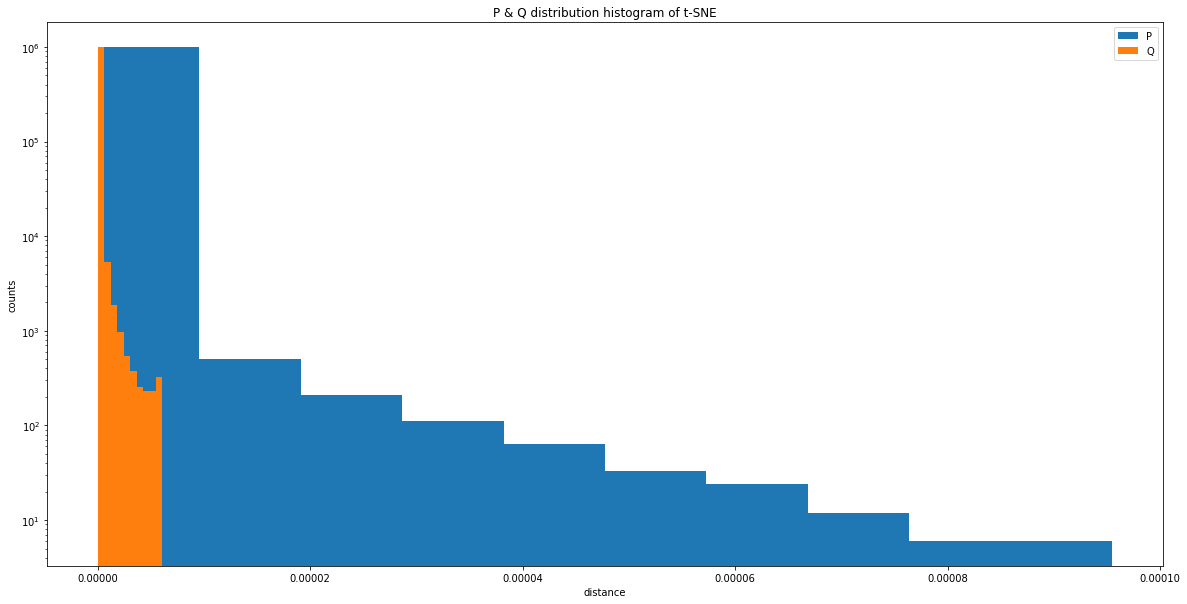

In [14]:
plt.figure(figsize=(20, 10))
plt.hist(np.random.choice(P_tsne.flatten(), size=1000000), log=True, label='P')
plt.hist(np.random.choice(Q_tsne.flatten(), size=1000000), log=True, label='Q')
plt.legend()
plt.title('P & Q distribution histogram of t-SNE')
plt.xlabel('distance')
plt.ylabel('counts')

### Q distance histogram comparison

The comparison of Q in T-SNE and SSNE shows that since T-SNE uses student's t-distribution, the distribution of Q in T-SNE extends to a larger value than in SSNE.  
And that is probably also the reason that T-SNE beats SSNE.

Text(0, 0.5, 'counts')

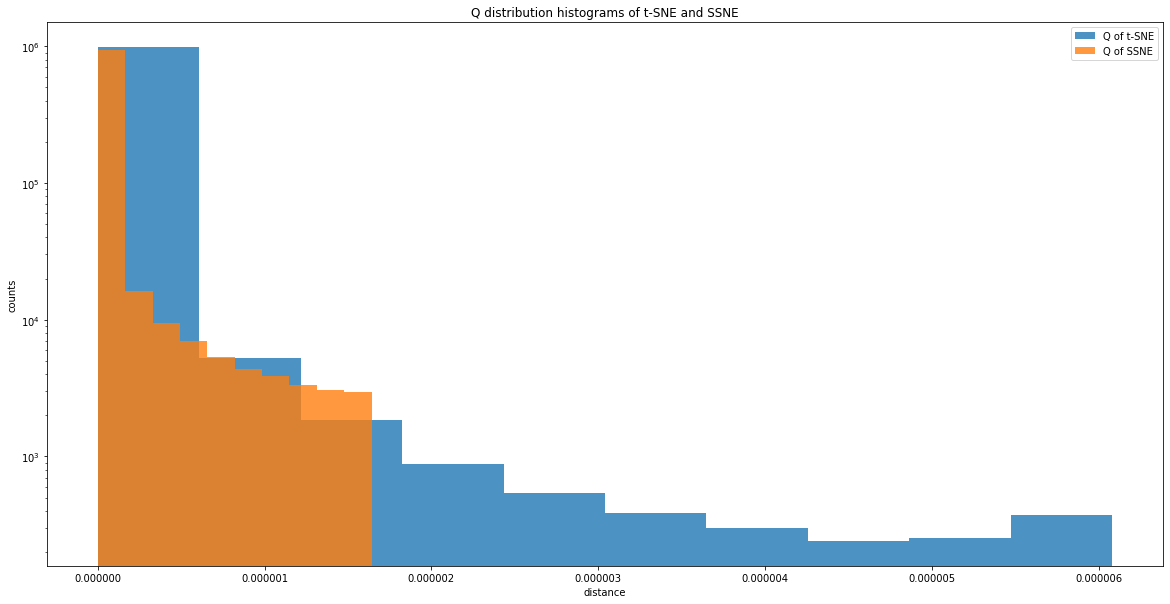

In [15]:
plt.figure(figsize=(20, 10))
plt.hist(np.random.choice(Q_tsne.flatten(), size=1000000), log=True, label='Q of t-SNE', alpha=0.8)
plt.hist(np.random.choice(Q_ssne.flatten(), size=1000000), log=True, label='Q of SSNE', alpha=0.8)
plt.legend()
plt.title('Q distribution histograms of t-SNE and SSNE')
plt.xlabel('distance')
plt.ylabel('counts')

## II. Eigenface

First the all face images are loaded into memory.

In [16]:
def load_faces(foldername='./faces'):
    # get all image filename
    filenames = glob.glob(foldername + '/*/*.pgm')
    
    imgs = list()
    for fn in filenames:
        imgs.append(plt.imread(fn))
        
    return np.array(imgs)
    
faces = load_faces()

Then, PCA is applied to reduce the data dimension to 25 degree.

In [17]:
faces_pcaed, face_vectors = pca(faces, rank=25, return_vectors=True)

### Eigenfaces

The 25 eigenfaces are shown below.  
Since the data's dimension is reduced to only 25 degrees, each eigenface can only represent a type of face roughly. 

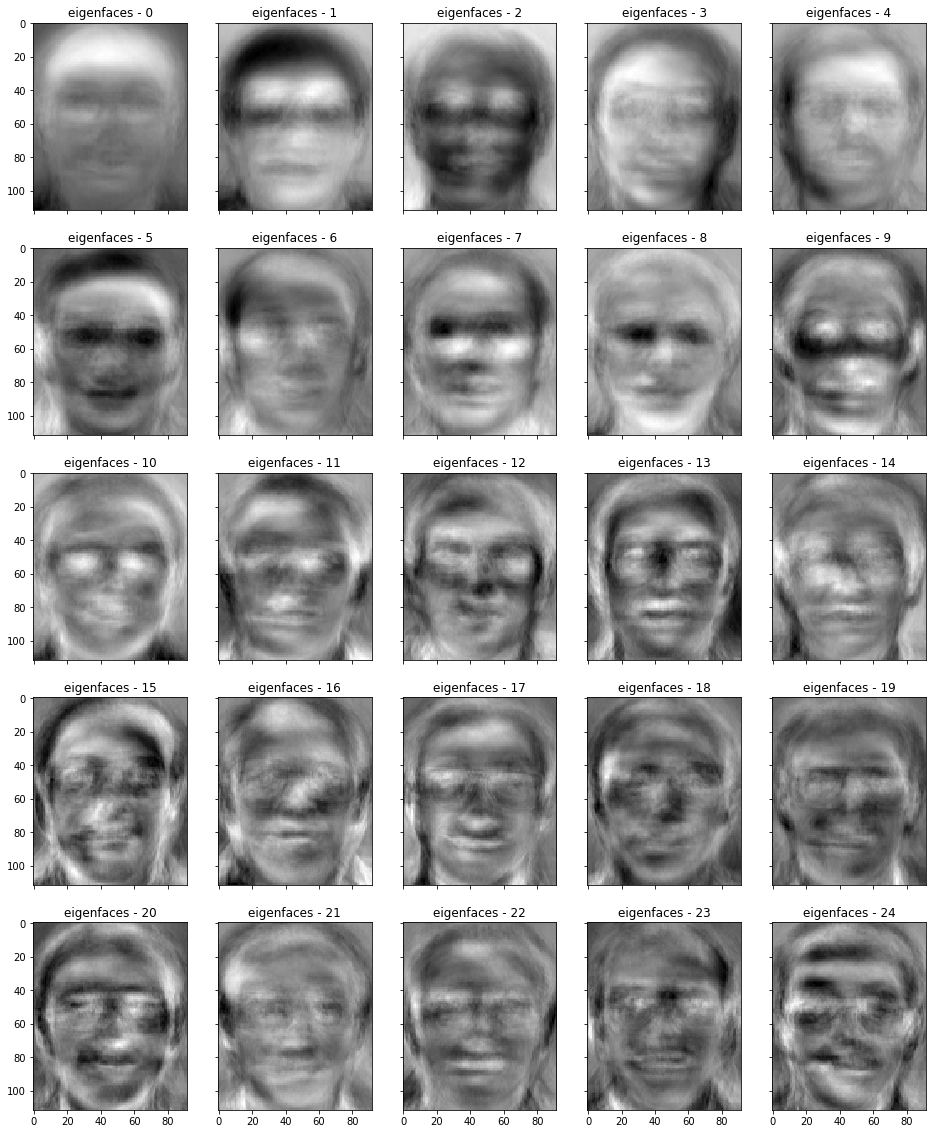

In [18]:
fig, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(16, 20))
for i, (fp, ax) in enumerate(zip(face_vectors, axes.flatten())):
    ax.imshow(fp.real, cmap='gray')
    ax.set_title('eigenfaces - {:d}'.format(i))
plt.show()

### Reconstruction

10 faces are chosen to perform dimension reduction and reconstruction.  
Again, since the majority of the information has been eliminated by the dimension reduction process, the reconstruction face won't be as accurate as of the original.  
The profile, however, can be approximately restored.

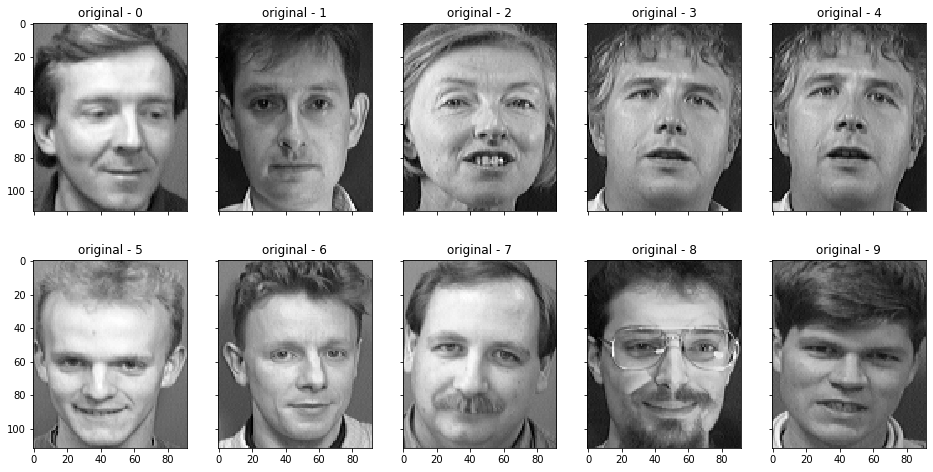

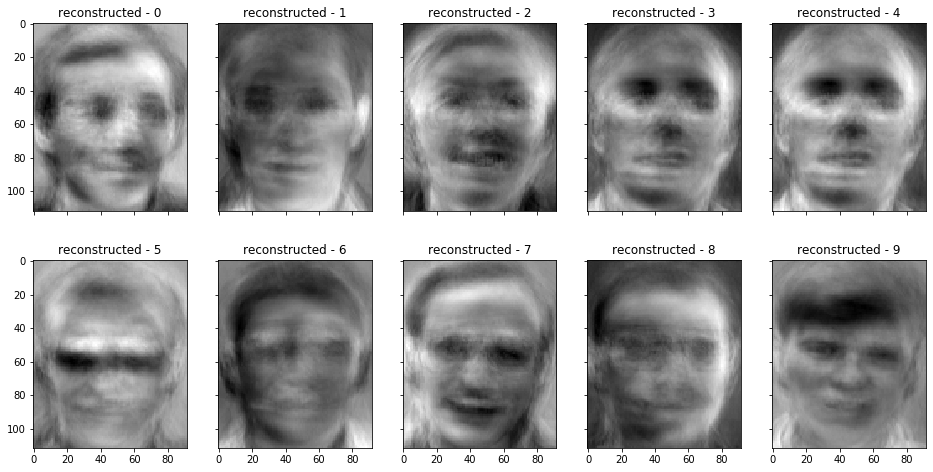

In [19]:
def reconstruct(face_pcaed, eigenfaces):
    return (eigenfaces * face_pcaed[..., np.newaxis, np.newaxis]).sum(axis=0)

chosen_indices = np.random.randint(faces_pcaed.shape[0], size=10)
chosen_faces = faces[chosen_indices]
chosen_faces_pcaed = faces_pcaed[chosen_indices]

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(16, 8))
for i, (cf, ax) in enumerate(zip(chosen_faces, axes.flatten())):
    ax.imshow(cf, 'gray')
    ax.set_title('original - {:d}'.format(i))
plt.show()

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(16, 8))
for i, (fp, ax) in enumerate(zip(chosen_faces_pcaed, axes.flatten())):
    ax.imshow(reconstruct(fp, face_vectors).real, cmap='gray')
    ax.set_title('reconstructed - {:d}'.format(i))
plt.show()